Imports

In [0]:
import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mount to Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Load data

Add alpha, beta

In [6]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NetworkingAI/aggData.csv')
df['alpha'] = (df['thput']/(df['thput']+df['rsrp']))
df['beta'] = (df['rsrp']/(df['thput']+df['rsrp']))
df.head(2)

,timestamp,resolution,playback_mode,buffer,rsrp,thput,alpha,beta
0,2019-09-21 13:58:00.000,1,1,4.214899,-104.0,24804,1.004211,-0.004211
1,2019-09-21 13:58:01.011,1,1,4.457133,-104.0,12402,1.008457,-0.008457


Grab "rsrp" and "buffer" for input features

Using time series data and "rsrp" to predict "buffer"

In [7]:
input_features = df.iloc[:,[4,3]].values
input_data = input_features
input_data

array([[-104.      ,    4.214899],
       [-104.      ,    4.457133],
       [-104.      ,    7.855983],
       ...,
       [-106.      ,   49.016383],
       [-106.      ,   48.007071],
       [-106.      ,   46.996016]])

Normalize the input data so all input features on scale from 0 to 1

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_features[:,:])
input_data

array([[3.35276100e-08, 5.66200447e-02],
       [3.35276100e-08, 5.85258453e-02],
       [3.35276100e-08, 8.52666430e-02],
       ...,
       [3.16649650e-08, 4.09100272e-01],
       [3.16649650e-08, 4.01159408e-01],
       [3.16649650e-08, 3.93204830e-01]])

Consider data from the previous 50 days

Take 30% of latest data for test dataset

In [0]:
# t contains [rsrp, thput] time series data of length 50
# x contains each t
# y contains thput time series data ahead of lookback

lookback = 50

test_size=int(.3 * len(df))
x=[]
y=[]
for i in range(len(df)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    x.append(t)
    y.append(input_data[i+ lookback,1])

LSTM expects the input data in a specific 3D format of (test sample size, time steps, number of input features).

In our case timesteps is 50 and number of input features is 2 (rsrp and buffer).

Convert input data X into an array and then use reshape() to convert to the specified 3D format.

In [10]:
x, y = np.array(x), np.array(y)
x_test = x[:test_size+lookback]
x = x.reshape(x.shape[0], lookback, 2)
x_test = x_test.reshape(x_test.shape[0], lookback, 2)

print(x.shape)
print(x_test.shape)

(17736, 50, 2)
(5386, 50, 2)


Build the RNN LSTM model

30 RNN cells stacked one after the other in the RNN, implementing an efficient stacked RNN.

return_sequences = True to return the last output in the output sequence.

input_shape will be of the 3D format of (sample size, time steps, no. of input features).

Output will have only one unit as this is a regression problem.

In [11]:
from keras import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(x.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Using TensorFlow backend.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


Compile the model using adam optimizer and loss function MSE for the regression problem.

Fit the model using a batch_size of 32 and 3 epochs.

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x, y, epochs=6, batch_size=32, validation_split=0.2)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 14188 samples, validate on 3548 samples
Epoch 1/6





14188/14188 [==============================] - 141s 10ms/step - loss: 0.0122 - val_loss: 0.0066
Epoch 2/6
14188/14188 [==============================] - 131s 9ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/6
14188/14188 [==============================] - 131s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 4/6
14188/14188 [==============================] - 131s 9ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/6
14188/14188 [==============================] - 130s 9ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 6/6
14188/14188 [==============================] - 131s 9ms/step - loss: 0.0028 - val_loss: 0.0029


Plot model performance of loss function on training/validation data

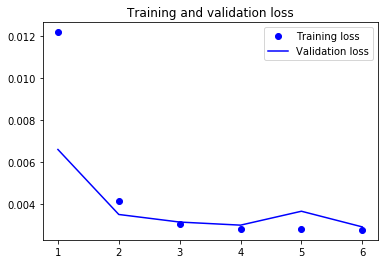

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
predicted_value = model.predict(x_test)

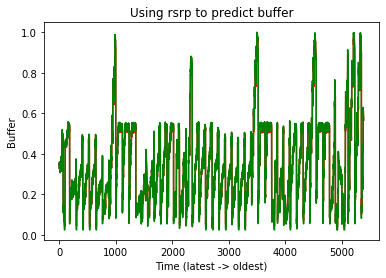

In [15]:
plt.plot(predicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Using rsrp to predict buffer")
plt.xlabel("Time (latest -> oldest)")
plt.ylabel("Buffer")
plt.show()

In [16]:
obs = input_data[lookback:test_size+(2*lookback),1] 
mse = (np.square(obs - predicted_value)).mean(axis=None)
mse

0.08160196546124464

Save files to Drive and push to GitHub

In [0]:
# copy all files to Google Drive
# !cp -r ./* "/content/drive/My Drive/Colab Notebooks/NetworkingAI"

# clone repo and transfer files to temp folder
!mkdir ./temp
!git clone "https://204739d2dfbc88497ba8be11b9ac8bf880feb428@github.com/dweinflash/NetworkingAI.git" ./temp
!rsync -aP --exclude=data/ "/content/drive/My Drive/Colab Notebooks/NetworkingAI"/* ./temp

# push files to github, remove temp
%cd ./temp
!git add .
!git commit -m '"first"'
!git config --global user.email "david.weinflash@gmail.com"
!git config --global user.name "dweinflash"
!git push origin "master"
%cd /content
!rm -rf ./temp

mkdir: cannot create directory ‘./temp’: File exists
fatal: destination path './temp' already exists and is not an empty directory.
sending incremental file list
293N.ipynb
         79,928 100%   44.98MB/s    0:00:00 (xfr#1, to-chk=183/184)
/content/temp
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


**Future iterations:**

*   Callbacks?
*   Increase epochs
*   Increase lookback
*   Use thput to predict buffer
*   Use both thput/rsrp to predict buffer
*   Use alpha to predict buffer
*   Use beta to predict buffer

**Video Quality Comparison**

Tool set for comparing two videos

How similar/different are they in quality?

OpenCV toolset? MatLab toolset?

Just a comparison problem - no ML

Derive the correlation between the two videos. Need to make your own unified metric?

Trouble with syncing up the start times of both videos

Comparison of two different video qualities

Sync up the videos so they start at the same frame

Source vs Output files

How similar is output file to source file?